<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Graphics" data-toc-modified-id="Graphics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Graphics</a></span></li></ul></li><li><span><a href="#Getting-Ready" data-toc-modified-id="Getting-Ready-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting Ready</a></span><ul class="toc-item"><li><span><a href="#Base-Integrator-Settings" data-toc-modified-id="Base-Integrator-Settings-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Base Integrator Settings</a></span></li><li><span><a href="#Initial-Conditions" data-toc-modified-id="Initial-Conditions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Initial Conditions</a></span></li></ul></li><li><span><a href="#Batch-Execution" data-toc-modified-id="Batch-Execution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Batch Execution</a></span></li></ul></div>

# Initialization

In [2]:
###### Do not touch
MinVersion = 22

import PyUltraLight2 as PyUL

if (PyUL.S_version < MinVersion):
    raise RuntimeError("You need the latest PyULN!")

import numpy as np

np.set_printoptions(suppress=True)

import math

import numba
import numexpr as ne
import time
import pyfftw
import os
import sys
import multiprocessing
import numpy

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec
import matplotlib.animation
from matplotlib.offsetbox import AnchoredText

import IPython
from IPython.core.display import clear_output, display, Video

from numpy import sqrt, exp, log, log10, sin, cos, tan, pi

%reload_ext autoreload
%autoreload 2


# Useful Aux Functions
ToCode = PyUL.convert
ToPhys = PyUL.convert_back
CB = PyUL.convert_between

printU = PyUL.printU


m22 = PyUL.axion_E / 1e-22

printU(f"m22 = {m22:.3g}", 'universe')


PyUL2.universe: m22 = 1


## Graphics

In [3]:
plt.style.use('default')

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["text.usetex"]= False
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.facecolor'] = 'w'

from matplotlib.colors import LinearSegmentedColormap
Palette = 'magma'
cyccol=['#000000', '#ffffff','#000000']
divcol=['#003262','#005b96','#ffffff','#d5a756','#B51700']
divcols=['#005b96','#ffffff','#d5a756']

CycPalette = LinearSegmentedColormap.from_list('myCyc', cyccol)

DivPalette  = LinearSegmentedColormap.from_list('myDiv', divcol)
DivPaletteS  = LinearSegmentedColormap.from_list('myDiv', divcols)

EFigSize = (20,12)
EFigSizeMono = (20,6)
VideoSize = (8,8)
FPS = 10
DPI = 72

FrameCap = 60 # Maximum Number of Frames to Animate

########################################

# BH Trajectory

Colors = np.array([[209,17,65],[0,177,89],[0,174,219],[243,119,53],[255,196,37]])/255

# NBody
ENStyle = '-'
ENColor = '#ff6c0e' # NBody

EKColor = '#8dd9e7'
EPColor = '#fd8dc8'

# ULDM
EUStyle = '-'
EUColor = '#7f1717' # ULDM

EQColor = '#ccb603' # Kinetic 
ERColor = '#6cc25c' # Self-Interaction
EGColor = '#2c8899' # Particle Potential

# Totals
ETStyle = '-'
ETColor = '#080808'

# Auxiliary 
HelperStyle = 'k.'
EmphColor = 'black'
GeomColor = 'olivedrab'

# Getting Ready

## Base Integrator Settings

In [4]:
resol = 128

length, length_units = 6, '' #
duration, duration_units = 1, '' #

start_time = 0. # For solitons only: Pre-evolve the wavefunction phase.

NS = 32

save_format = 'npy' # npy, npz, hdf5

step_factor = 1 # Keep it on default

save_number = 300

PyUL.DispN(duration,duration_units,length,length_units,resol,step_factor,save_number)

# You can also set it to 'Minimum' to only save all 1D mesh Data.
Save_Options = '2Density Energy NBody DF Entropy'

#This Boolean List is for program's internal use
save_options = PyUL.SaveOptionsDigest(Save_Options)

s_mass_unit = ''
s_position_unit = ''
s_velocity_unit = '' 
m_mass_unit = s_mass_unit
m_position_unit = s_position_unit
m_velocity_unit = s_velocity_unit


Uniform = False # if True, then there won't be solitons.
Density = 0
UVel = [0,0,0] # Uses s_velocity_units
density_unit = '' # Accepted units: 'MSol/pc3', 'kg/m3', and '' for dimensionless units

The required number of ULDM steps is 1430
The actual ULDM steps is 1500


0.23809523809523808

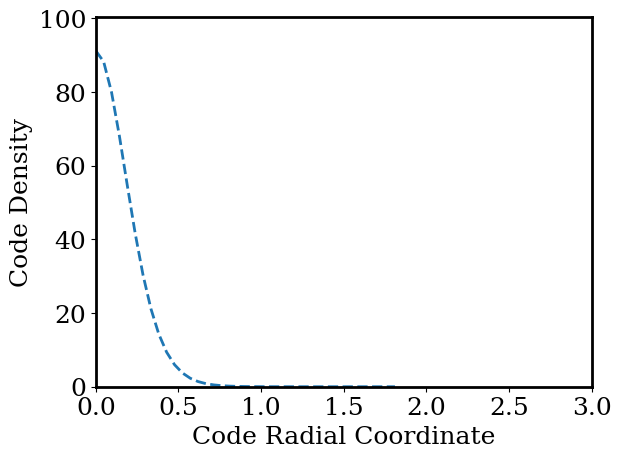

In [20]:
mS = 12 # User Input

Phase = 0 # Multiples of pi

PyUL.SolitonSizeEstimate(mS,length,resol,s_mass_unit,length_units, Plot = True)

## Initial Conditions

In [16]:
save_path = 'Batches/MR'

PyUL.DSManagement(save_path, Force = False)

[ Batches/MR ] : The current size of the folder is 3.315 Mib
[ Batches/MR ] : Do You Wish to Delete All Files Currently Stored In This Folder? [Y] 

Y
Folder Cleaned! 

[ Batches/MR ] : Save Folder Created.


In [21]:
RatioList = [0,0.0001,0.001,0.01,0.1]
RadiusList = [0.05,0.1,0.2,0.4,0.8,1.6]

N = len(RatioList) * len(RadiusList)

I = 0

for i in range(len(RatioList)):
    
    Ratio = RatioList[i]
    
    for j in range(len(RadiusList)):
        
        I+=1
        
        r0 = RadiusList[i]

        gridspace = PyUL.MeshSpacing(resol,length,length_units, silent = True)
        
        rP = 1/2 * gridspace

        a = PyUL.GenPlummer(rP,length_units)

        mP = mS * Ratio# User Input

        MIn, vRel0 = PyUL.DefaultSolitonOrbit(resol,length, length_units, mS, s_mass_unit, r0,
                                              m_position_unit, m_velocity_unit, Detail = int(7e4))


        #================================================================
        # Do not touch

        M = mS + mP
        # Unit 1
        y1 = 0
        x1 = r0*mS/M
        yDot1 = vRel0*mS/M

        # Unit 2
        y2 = 0
        x2 = r0*mP/M
        yDot2 = vRel0*mP/M

        embeds    = []
        particles =  [[mP,[x1,y1,0],[0,-yDot1,0]]]
        solitons  =  [[mS,[-x2,-y2,0],[0,yDot2,0],Phase*np.pi]]

        plt.show()

        Name = f'M{Ratio:.5f}_R{r0:.5f}'

        Initpath = ''

        run_folder = PyUL.GenerateConfig(NS, length, length_units,
                                         resol, duration, duration_units, step_factor,
                                         save_number, Save_Options, save_path,
                                         save_format, s_mass_unit, s_position_unit,
                                         s_velocity_unit, solitons,start_time,
                                         m_mass_unit, m_position_unit, m_velocity_unit,
                                         particles,embeds, Uniform,Density,density_unit,
                                         a,UVel,True,Name)
        
        
print('Done!', f'Initialized {I} simulations.')

Done! Initialized 30 simulations.


[**Back to the Top**](#root)
<a id='run'></a>
# Batch Execution

This creates a timestamped folder using the current settings, and the integrator stores all requested files in it too.

In [15]:
FullSim = True
Shift = False
T0 = time.time()
runs = os.listdir(save_path)
runs.sort()

NRuns = len(runs)

Run = 0

for run_folder in runs:
    
    if os.path.isdir(f'{save_path}/{run_folder}'):
        
        RunText = f'Simulation #{Run+1} out of {NRuns}'
        PyUL.evolve(save_path,run_folder,
            NBodyInterp = FullSim, SelfGravity = FullSim, NBodyGravity = True, 
            Silent = True, Shift = Shift, AutoStop = False, AutoStop2 = False, Message = RunText,
                   Stream = False, StreamChar = [1,4])

        Run +=1

        print(f'Simulation {Run} finished.')
        time.sleep(2)
        
import IPython
IPython.display.Audio("Done.mp3",autoplay=True)

print(f"{time.time()-T0:.3g}s")
printU('Please copy this into analysis notebook\n\nbatch_path = \''+batch_path+'\'','Export')

Build 2021 Jun 01
Message: Simulation #1 out of 5
PyUL2.Runtime: Simulation name is ./Batches/MR/M0.00000_R0.05000
PyUL2.Runtime: 128 Resolution for 1
PyUL2.Runtime: Simulation Started at 02/06/2021, 16:43:31.
PyUL2.Runtime: Taking 1500 ULDM steps @ 300 snapshots


[○○○○○○○○○◎●◎○○○○○○○○] 8% FT   Exp. Time: 02/06/2021, 16:46:41 (Prev.: 0.13s) [V=0.33 / Tg.V=0.00]

KeyboardInterrupt: 